# Pel·lícules de Netflix, Prime Video, Hulu i Disney+

1600123 | Alba Fernández Coronado

In [1]:
# Carregant les llibreries necessàries
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import collections as col
import scipy.stats as stats
import statsmodels.api as sm
import scipy.stats
import random as rand
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder, StandardScaler, scale, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings
import time
from yellowbrick.target import FeatureCorrelation
import statistics as st
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

warnings.filterwarnings("ignore")

### EDA I PREPROCESSING

In [2]:
# Obrint el dataset
dataset = pd.read_csv('./MoviesOnStreamingPlatforms.csv')
print(f'Mida de les dades: {dataset.shape}')
dataset.info() # Entenent els tipus de variables de cada atribut
dataset.head()

Mida de les dades: (9515, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9515 entries, 0 to 9514
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       9515 non-null   int64 
 1   ID               9515 non-null   int64 
 2   Title            9515 non-null   object
 3   Year             9515 non-null   int64 
 4   Age              5338 non-null   object
 5   Rotten Tomatoes  9508 non-null   object
 6   Netflix          9515 non-null   int64 
 7   Hulu             9515 non-null   int64 
 8   Prime Video      9515 non-null   int64 
 9   Disney+          9515 non-null   int64 
 10  Type             9515 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 817.8+ KB


,Unnamed: 0,ID,Title,Year,Age,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type
0,0,1,The Irishman,2019,18+,98/100,1,0,0,0,0
1,1,2,Dangal,2016,7+,97/100,1,0,0,0,0
2,2,3,David Attenborough: A Life on Our Planet,2020,7+,95/100,1,0,0,0,0
3,3,4,Lagaan: Once Upon a Time in India,2001,7+,94/100,1,0,0,0,0
4,4,5,Roma,2018,18+,94/100,1,0,0,0,0


In [3]:
#S'eliminen les columnes innecessàries del dataset
dataset_df = dataset.drop(["Unnamed: 0", "ID"], axis=1)
#Es mira la columna Type --> Type Movie: 0 TV Show: 1
print("Tipus de valors columna Type: ",dataset_df['Type'].nunique()) #quants tipus de valors hi ha: 1
print("Valors únics columna Type: ",dataset_df['Type'].unique()) #quins són els valors únics: 0
dataset_df = dataset_df.drop(["Type"], axis=1) #Eliminem la columna Type pq totes les pelis són Movies
dataset_df.head()

Tipus de valors columna Type:  1
Valors únics columna Type:  [0]


,Title,Year,Age,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+
0,The Irishman,2019,18+,98/100,1,0,0,0
1,Dangal,2016,7+,97/100,1,0,0,0
2,David Attenborough: A Life on Our Planet,2020,7+,95/100,1,0,0,0
3,Lagaan: Once Upon a Time in India,2001,7+,94/100,1,0,0,0
4,Roma,2018,18+,94/100,1,0,0,0


In [4]:
#Mirem el percentatge de valors Null
(dataset_df.isnull().sum()/len(dataset))*100

Title               0.000000
Year                0.000000
Age                43.899107
Rotten Tomatoes     0.073568
Netflix             0.000000
Hulu                0.000000
Prime Video         0.000000
Disney+             0.000000
dtype: float64

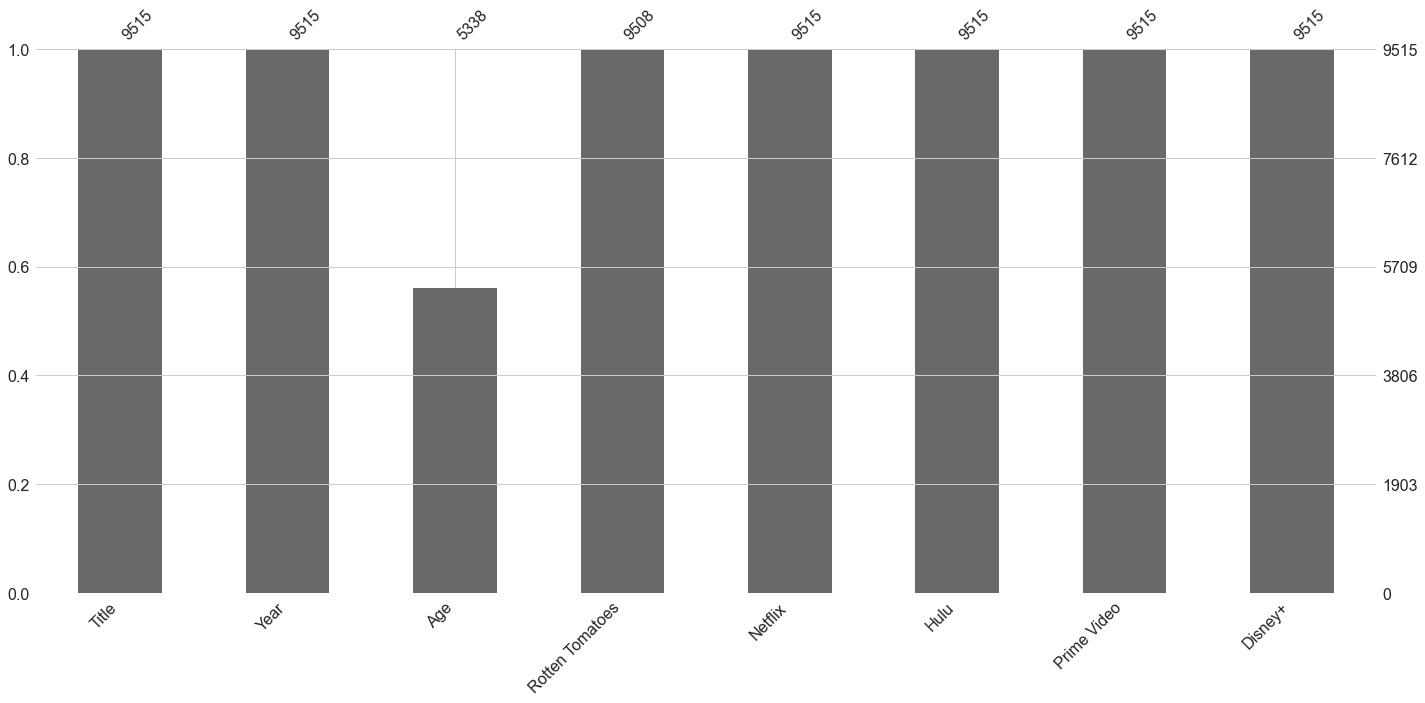

In [5]:
import missingno as msno
# plotting the number of rows with entries per column
msno.bar(dataset_df)

In [6]:
#Eliminem les files que continguin NaNs a la variable resposta (Rotten Tomatoes) pq no ens interessen
dataset_df = dataset_df[dataset_df['Rotten Tomatoes'].notna()]

(dataset_df.isnull().sum()/len(dataset_df))*100

Title               0.000000
Year                0.000000
Age                43.857804
Rotten Tomatoes     0.000000
Netflix             0.000000
Hulu                0.000000
Prime Video         0.000000
Disney+             0.000000
dtype: float64

In [7]:
#Tractem les dades tipus objecte
dataset_df['Rotten Tomatoes'] = (dataset_df['Rotten Tomatoes'].str.split("/", n=1).str[0].astype("int"))/100

#Tractem la columna Age
dataset_df['Age'].fillna(0, inplace=True) #omplim els nans amb 0
edats = {"18+": 18, "7+": 7, "13+": 13, "16+": 16, "all": 0, 0:0}
dataset_df['Age'] = [edats[item] for item in dataset_df['Age']]
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9508 entries, 0 to 9514
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            9508 non-null   object 
 1   Year             9508 non-null   int64  
 2   Age              9508 non-null   int64  
 3   Rotten Tomatoes  9508 non-null   float64
 4   Netflix          9508 non-null   int64  
 5   Hulu             9508 non-null   int64  
 6   Prime Video      9508 non-null   int64  
 7   Disney+          9508 non-null   int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 668.5+ KB


In [8]:
#Ara que ja tenim les edats en int i sense cap NaN, afegim una columna per mirar si les pelis tenen restricció d'edat o no
dataset_df['Age_Restricted'] = np.where(dataset_df['Age'] == 0, 0, 1)
dataset_df.head()

,Title,Year,Age,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Age_Restricted
0,The Irishman,2019,18,0.98,1,0,0,0,1
1,Dangal,2016,7,0.97,1,0,0,0,1
2,David Attenborough: A Life on Our Planet,2020,7,0.95,1,0,0,0,1
3,Lagaan: Once Upon a Time in India,2001,7,0.94,1,0,0,0,1
4,Roma,2018,18,0.94,1,0,0,0,1


Text(0.5, 1.0, "Any d'estreno de les pel·lícules")

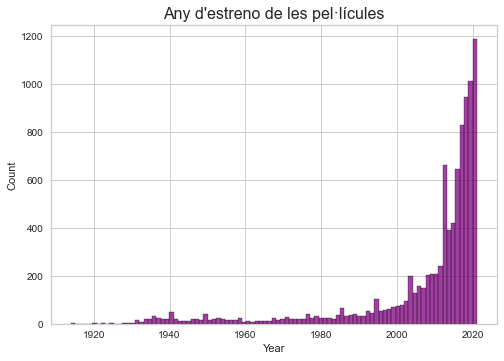

In [9]:
#Es grafiquen el nombre de pelis per any
sns.histplot(data=dataset_df, x="Year", color="purple")
plt.title("Any d'estreno de les pel·lícules", fontsize=16)

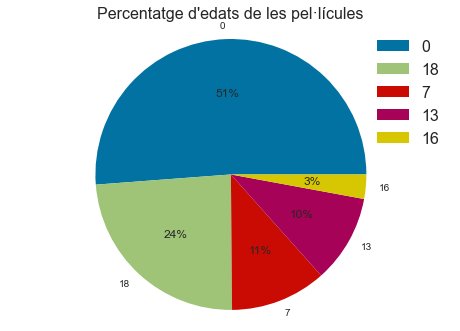

In [10]:
#Es grafiquen els percentatges d'edat
count_edats = [dataset_df['Age'].value_counts()]
noms_edats = ["0","18","7","13","16"]
plt.pie(count_edats, labels=noms_edats, autopct='%1.0f%%')
plt.axis("equal")
plt.title("Percentatge d'edats de les pel·lícules", fontsize=16)
plt.legend(loc='best', facecolor='w', fontsize=16)
plt.show()

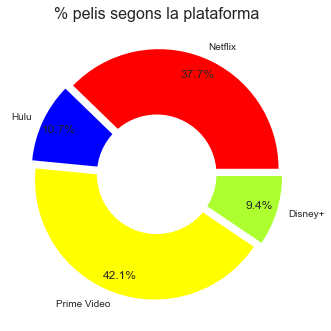

In [11]:
#Gràfic segons el percentatge de pelis que té cada plataforma
Plataformes = ['Netflix', 'Hulu', 'Prime Video', 'Disney+']
rows = len(dataset_df.axes[0])
nombre_pelis = [dataset_df['Netflix'].sum()/rows, dataset_df['Hulu'].sum()/rows, 
                dataset_df['Prime Video'].sum()/rows, dataset_df['Disney+'].sum()/rows]
colors = ['#FF0000', '#0000FF', '#FFFF00', '#ADFF2F']
explode = (0.05, 0.05, 0.05, 0.05)

# Pie Chart
plt.pie(nombre_pelis, colors=colors, labels=Plataformes,
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)
  
# draw circle
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('% pelis segons la plataforma', fontsize=16)
  
# Displaying Chart
plt.show()

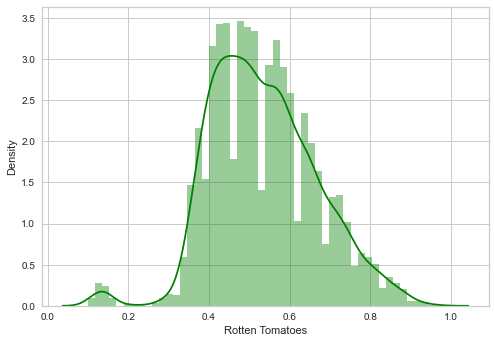

In [30]:
#Gràfic de la variable resposta
sns.distplot(dataset_df['Rotten Tomatoes'], color= 'green')

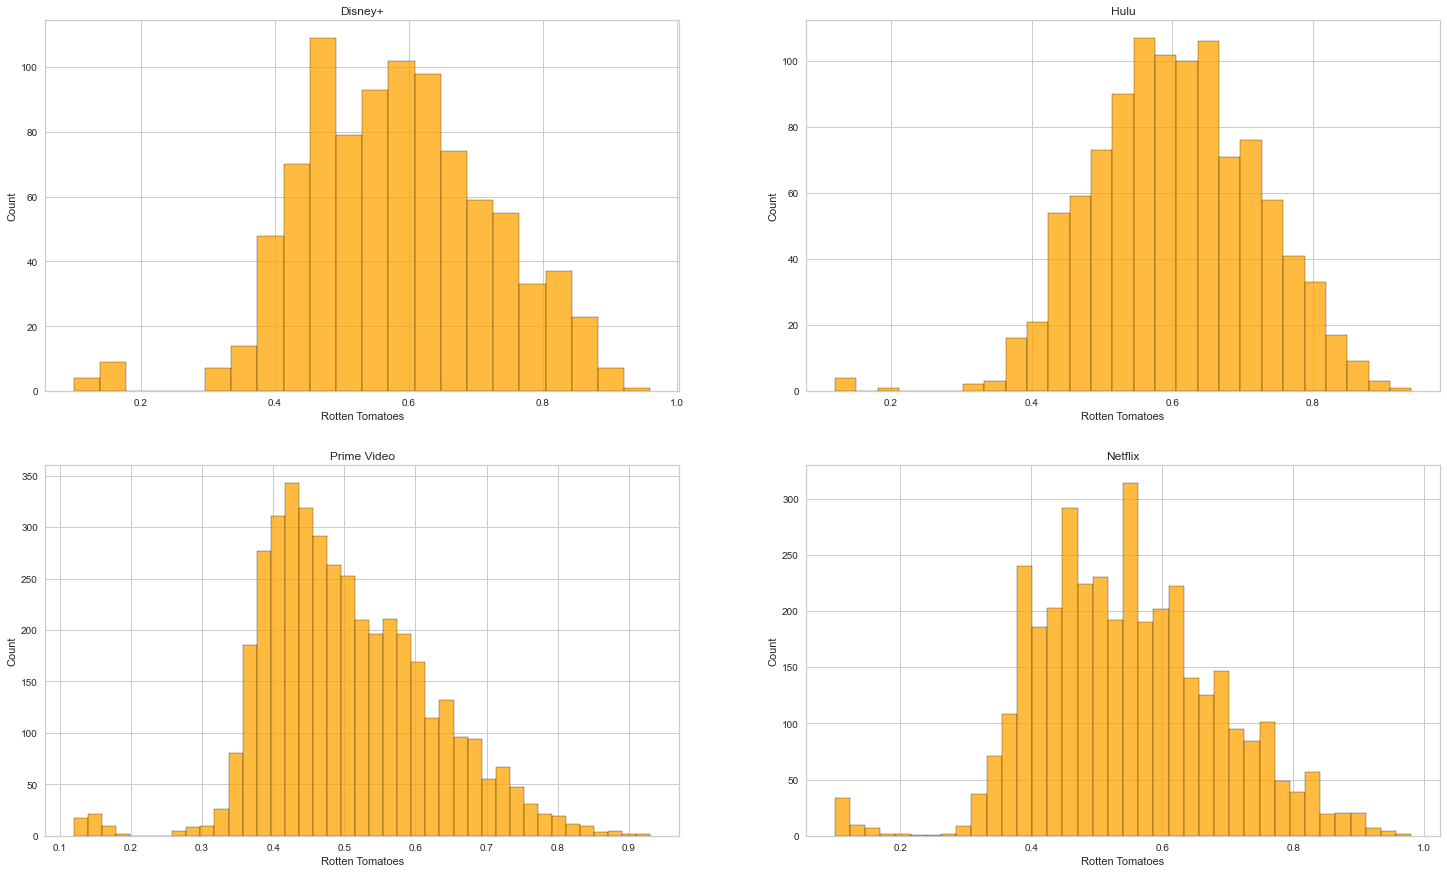

In [12]:
#Gràfic de les puntuacions de les pelis segons la plataforma
#Disney+
dataset_Disney = dataset_df[dataset_df['Disney+'] ==1]
punt_disney = dataset_Disney['Rotten Tomatoes']
#Hulu
dataset_Hulu = dataset_df[dataset_df['Hulu'] ==1]
punt_hulu = dataset_Hulu['Rotten Tomatoes']
#Prime Video
dataset_Prime = dataset_df[dataset_df['Prime Video'] ==1]
punt_prime = dataset_Prime['Rotten Tomatoes']
#Netflix
dataset_Netflix = dataset_df[dataset_df['Netflix'] ==1]
punt_netflix = dataset_Netflix['Rotten Tomatoes']

#Fem els histogrames
fig = plt.figure(figsize=(25,15))
ax1 = fig.add_subplot(2, 2, 1) 
ax1.set_title('Disney+') 
ax2 = fig.add_subplot(2, 2, 2) 
ax2.set_title('Hulu')
ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title('Prime Video')
ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title('Netflix')
sns.histplot(data=dataset_Disney, x='Rotten Tomatoes', color="orange", ax=ax1)
sns.histplot(data=dataset_Hulu, x='Rotten Tomatoes', color="orange", ax=ax2)
sns.histplot(data=dataset_Prime, x='Rotten Tomatoes', color="orange", ax=ax3)
sns.histplot(data=dataset_Netflix, x='Rotten Tomatoes', color="orange", ax=ax4)
plt.show()

Dinsey+: 0.5831236442516261 Hulu: 0.6039732569245457 Prime Video: 0.5039873571602426 Netflix 0.5444793926247375


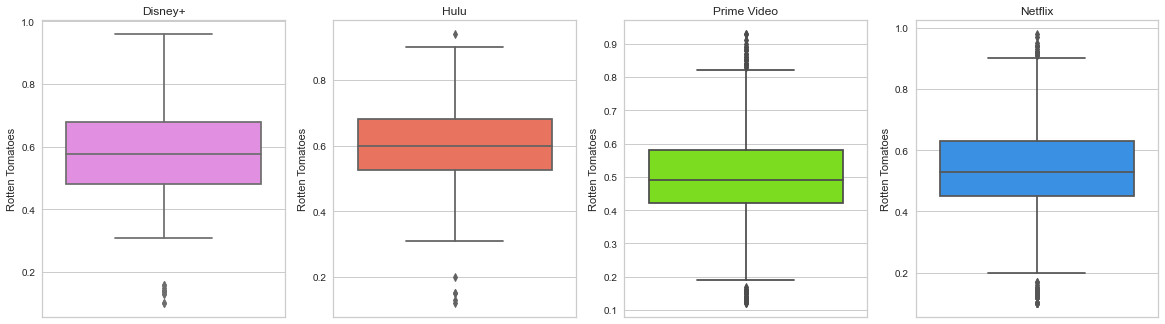

In [13]:
#Més concretament, boxplot mitjana de puntuació de cada plataforma
print("Dinsey+:", dataset_Disney['Rotten Tomatoes'].mean(), "Hulu:", dataset_Hulu['Rotten Tomatoes'].mean(),
     "Prime Video:", dataset_Prime['Rotten Tomatoes'].mean(), "Netflix", dataset_Netflix['Rotten Tomatoes'].mean())
#Fem els histogrames
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(2, 4, 1) 
ax1.set_title('Disney+') 
ax2 = fig.add_subplot(2, 4, 2) 
ax2.set_title('Hulu')
ax3 = fig.add_subplot(2, 4, 3)
ax3.set_title('Prime Video')
ax4 = fig.add_subplot(2, 4, 4)
ax4.set_title('Netflix')
sns.boxplot(data=dataset_Disney, y="Rotten Tomatoes", color="violet", ax=ax1)
sns.boxplot(data=dataset_Hulu, y="Rotten Tomatoes", color = "tomato", ax=ax2)
sns.boxplot(data=dataset_Prime, y="Rotten Tomatoes", color="lawngreen", ax=ax3)
sns.boxplot(data=dataset_Netflix, y="Rotten Tomatoes", color="dodgerblue", ax=ax4)
plt.show()

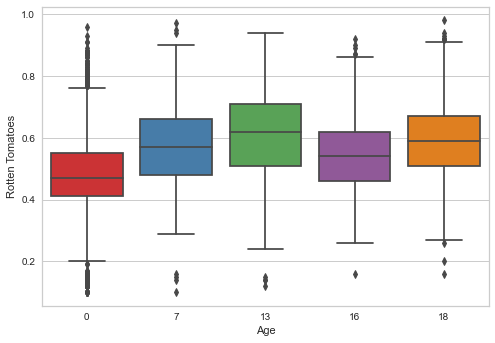

In [24]:
#Ara fem un gràfic de les puntuacions de les pelis segons el grup d'edat al que estan destinades

sns.boxplot(data=dataset_df, x="Age", y="Rotten Tomatoes", palette="Set1")

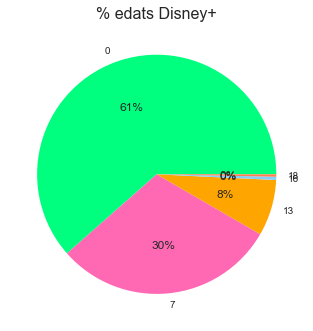

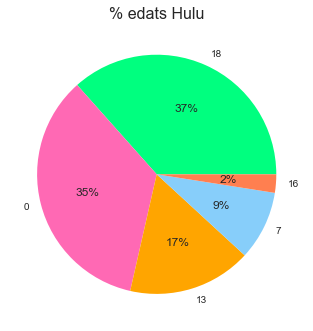

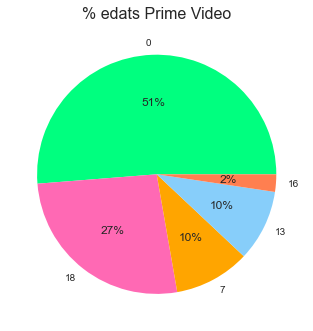

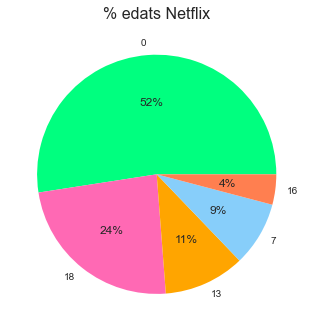

In [16]:
#Es grafiquen les edats segons les plataformes
mycolors = ["springgreen", "hotpink", "orange", "lightskyblue", "coral"]
plt.pie(dataset_Disney['Age'].value_counts(), labels = ["0","7","13","16","18"], colors= mycolors, autopct='%.0f%%')
plt.title("% edats Disney+", fontsize=16)
plt.show()
plt.pie(dataset_Hulu['Age'].value_counts(), labels = ["18","0","13","7","16"], colors= mycolors, autopct='%.0f%%')
plt.title("% edats Hulu", fontsize=16)
plt.show()
plt.pie(dataset_Prime['Age'].value_counts(), labels = ["0","18","7","13","16"], colors= mycolors, autopct='%.0f%%')
plt.title("% edats Prime Video", fontsize=16)
plt.show()
plt.pie(dataset_Netflix['Age'].value_counts(), labels = ["0","18","13","7","16"], colors= mycolors, autopct='%.0f%%')
plt.title("% edats Netflix", fontsize=16)
plt.show()

Dinsey+: 3.225596529284165 Hulu: 9.809933142311365 Prime Video: 7.118891320204231 Netflix 6.9707158351409975


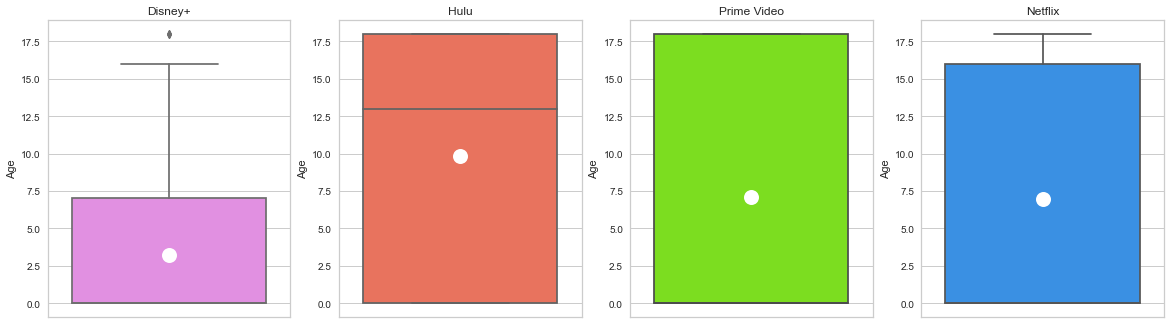

In [15]:
#Boxplot mitjana d'edat de cada plataforma

print("Dinsey+:", dataset_Disney['Age'].mean(), "Hulu:", dataset_Hulu['Age'].mean(),
     "Prime Video:", dataset_Prime['Age'].mean(), "Netflix", dataset_Netflix['Age'].mean())
#Fem els histogrames
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(2, 4, 1) 
ax1.set_title('Disney+') 
ax2 = fig.add_subplot(2, 4, 2) 
ax2.set_title('Hulu')
ax3 = fig.add_subplot(2, 4, 3)
ax3.set_title('Prime Video')
ax4 = fig.add_subplot(2, 4, 4)
ax4.set_title('Netflix')
sns.boxplot(data=dataset_Disney, y="Age", color="violet",showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", "markersize":"15"}, ax=ax1)
sns.boxplot(data=dataset_Hulu, y="Age", color = "tomato", showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", "markersize":"15"}, ax=ax2)
sns.boxplot(data=dataset_Prime, y="Age", color="lawngreen", showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", "markersize":"15"}, ax=ax3)
sns.boxplot(data=dataset_Netflix, y="Age", color="dodgerblue", showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", "markersize":"15"}, ax=ax4)
plt.show()

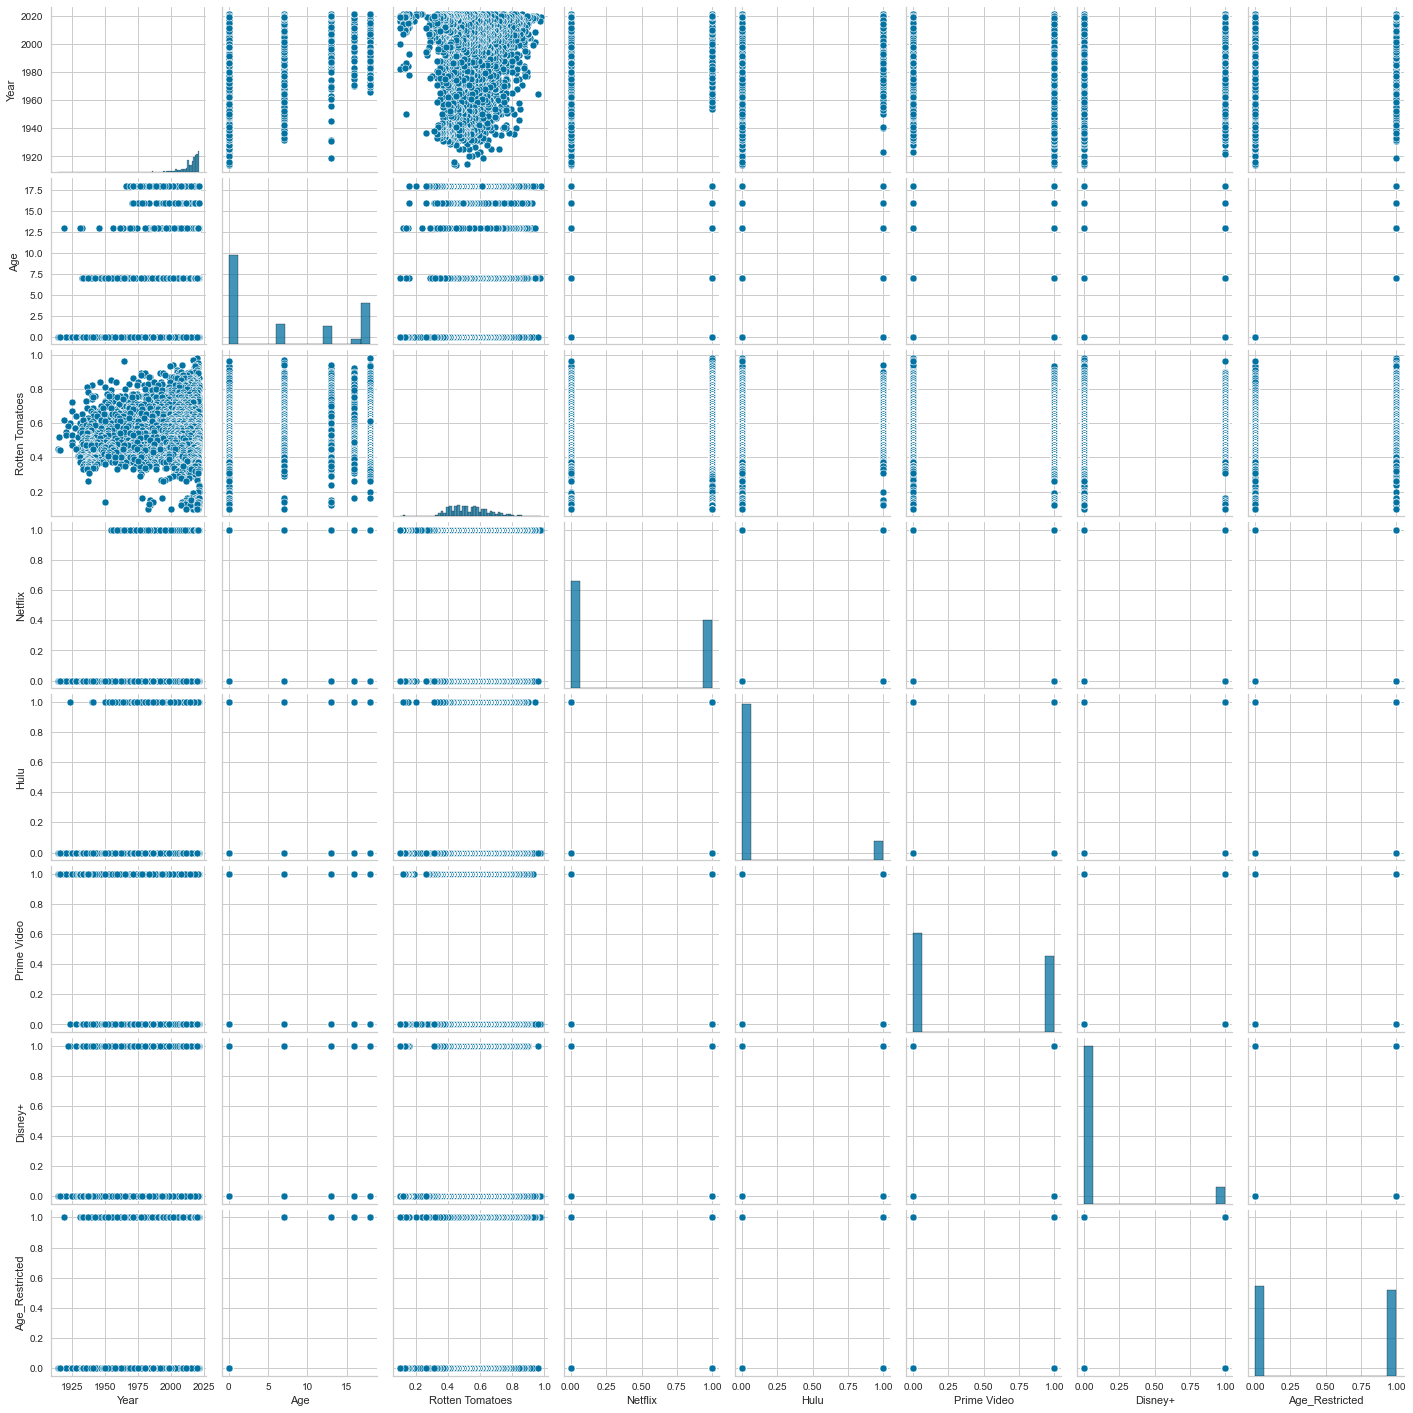

In [32]:
sns.pairplot(dataset_df)

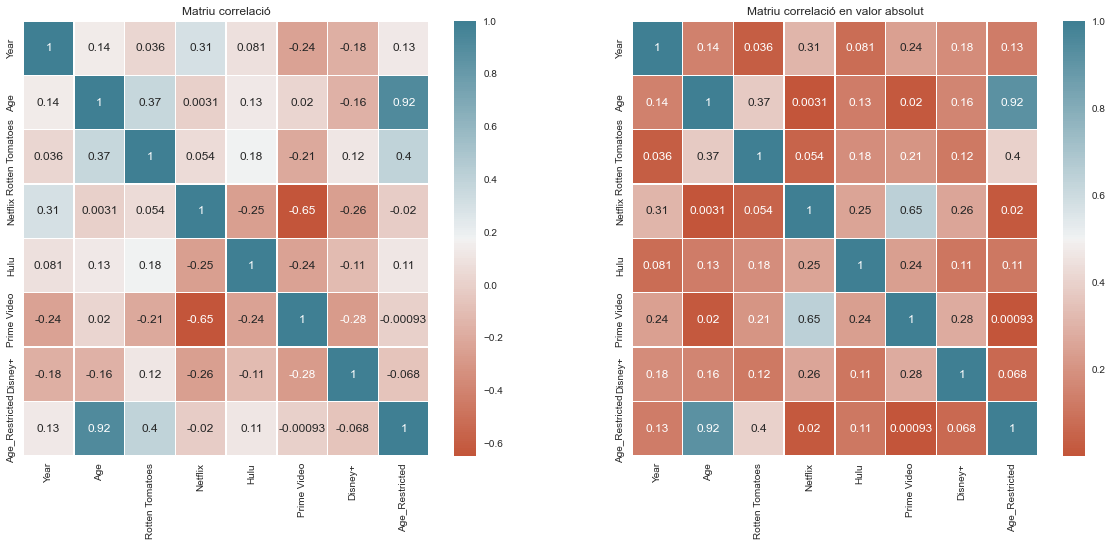

In [17]:
# Estudi de la correlació entre els atributs
correlacio = dataset_df.corr()

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1, 2, 1) 
ax1.set_title('Matriu correlació') 
ax2 = fig.add_subplot(1, 2, 2) 
ax2.set_title('Matriu correlació en valor absolut')

sns.heatmap(correlacio, annot=True, linewidths=.5, cmap = sns.diverging_palette(20, 220, n=200), ax=ax1)
sns.heatmap(abs(correlacio), annot=True, linewidths=.5, cmap = sns.diverging_palette(20, 220, n=200), ax=ax2)
plt.show()

In [18]:
#S'agafen tots els atributs que no siguin object
NoObj_data = dataset_df[dataset_df.select_dtypes(exclude=['object']).columns]

# Agafem la intersecció entre el dataset_df i el dataset sense atributs objecte per tractar els outliers posteriorment
intersect = list(set(dataset_df.columns).intersection(list(NoObj_data.columns)))
NoObj_data = dataset_df[intersect]
# NoObj_data.describe()

,Hulu,Age,Year,Prime Video,Netflix,Age_Restricted,Disney+,Rotten Tomatoes
count,9508.000000,9508.000000,9508.000000,9508.000000,9508.000000,9508.000000,9508.000000,9508.000000
mean,0.110118,6.940261,2007.416386,0.432583,0.387884,0.488010,0.096971,0.535450
std,0.313053,7.757894,19.134883,0.495460,0.487293,0.499883,0.295934,0.131977
min,0.000000,0.000000,1914.000000,0.000000,0.000000,0.000000,0.000000,0.100000
25%,0.000000,0.000000,2006.000000,0.000000,0.000000,0.000000,0.000000,0.440000
50%,0.000000,0.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.520000
75%,0.000000,16.000000,2018.000000,1.000000,1.000000,1.000000,0.000000,0.620000
max,1.000000,18.000000,2021.000000,1.000000,1.000000,1.000000,1.000000,0.980000


      Hulu  Age  Year  Prime Video  Netflix  Age_Restricted  Disney+
0        0   18  2019            0        1               1        0
1        0    7  2016            0        1               1        0
2        0    7  2020            0        1               1        0
3        0    7  2001            0        1               1        0
4        0   18  2018            0        1               1        0
...    ...  ...   ...          ...      ...             ...      ...
9510     0    0  2020            0        0               0        1
9511     0    0  2020            0        0               0        1
9512     0    0  2019            0        0               0        1
9513     0    0  2011            0        0               0        1
9514     0    7  2019            0        0               1        1

[9508 rows x 7 columns]
0       0.98
1       0.97
2       0.95
3       0.94
4       0.94
        ... 
9510    0.14
9511    0.13
9512    0.13
9513    0.10
9514    0.10
Name

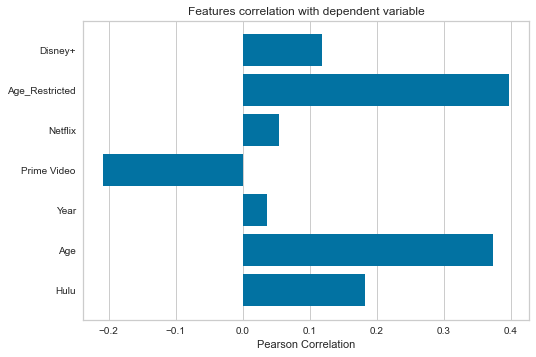

In [27]:
# Correlacio dels atributs amb la variable objectiu (només dels atributs numèrics)
X = NoObj_data.drop(['Rotten Tomatoes'], axis=1)
print(X)
Y = NoObj_data['Rotten Tomatoes']
print(Y)
feature_names = list(X.columns)
visualizer = FeatureCorrelation(labels = feature_names)
visualizer.fit(X, Y)
visualizer.poof()

In [20]:
#Ara que ja tenim X i Y separades, Normalitzem les dades
scaler = StandardScaler()
X_scale = pd.DataFrame(scaler.fit_transform(X))
X_cols = X.columns
X_scale.columns = X_cols

In [21]:
#Estudi dels outliers

MiceImputed = NoObj_data.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(NoObj_data)

# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.05)
Q3 = MiceImputed.quantile(0.95)
IQR = Q3 - Q1
total_outlier_num = ((NoObj_data < (Q1 - 1.5 * IQR)) | (NoObj_data > (Q3 + 1.5 * IQR))).sum()
print(total_outlier_num)

# Removing outliers from the dataset
# dataset_cp = dataset_cp[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
# dataset_cp.info()

#El dataset no té outliers, per tant, no els hem de tractar

Hulu               0
Age                0
Year               0
Prime Video        0
Netflix            0
Age_Restricted     0
Disney+            0
Rotten Tomatoes    0
dtype: int64


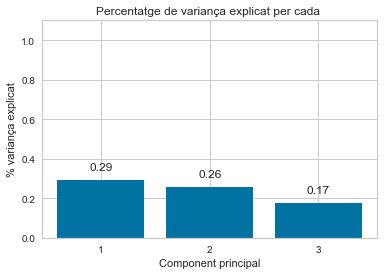

In [22]:
#Igualment, es fa un pca per visualitzar els outliers
model = PCA(n_components=3)
model.fit(X_scale)
data_pca = pd.DataFrame(
    data = model.components_,
    columns = X.columns,
    index = ['PC1','PC2','PC3'])
X_pca = model.transform(X_scale)

# Percentatge de variança de cada component
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(model.n_components_) + 1,
    height = model.explained_variance_ratio_
)

for x, y in zip(np.arange(len(data_pca.columns)) + 1, model.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(model.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Percentatge de variança explicat per cada ')
ax.set_xlabel('Component principal')
ax.set_ylabel('% variança explicat');

#Conclusió: com les variances són molt baixes, no val la pena fer un PCA.

### MODEL SELECTION